In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

tf.compat.v1.enable_v2_behavior()

from curiosity import m_passthrough_action

import pixiedust

Pixiedust database opened successfully


In [3]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule as pruning_sched
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

In [4]:
def matrix_dist(A, B):
    return np.linalg.norm((A - B).flatten(), ord=1)

In [5]:
# "model of the environment"
A = np.array([
    [1,0,1,0], # state and action, gives s_1
    [0,1,0,1],
])

# transform for the state
Q1 = np.random.randn(2, 2)

# transform for state+action
Q = np.eye(4)
Q[:2, :2] = Q1

# number of data pts
N = 1000

# states
xs = np.random.randn(4, N)

# next states
ys = A @ xs

xs_e = Q @ xs
ys_e = Q1 @ ys

# states
xs = xs.T
ys = ys.T

# observations
xs_e = xs_e.T
ys_e = ys_e.T

In [6]:
# checking that the model works correctly
assert np.allclose(A @ (np.linalg.inv(Q) @ xs_e[0]), ys[0])
assert np.allclose(xs_e[0][2:], xs[0][2:])

1000/1000 [==============================] - 0s 39us/sample - loss: 0.0060
0.00602556537091732
[<tf.Variable 'sequential/dense/kernel:0' shape=(4, 2) dtype=float32, numpy=
array([[ 1.0065782e+00, -1.8313839e-04],
       [ 3.7042825e-03,  9.9045521e-01],
       [ 8.8860834e-01,  2.9950993e-04],
       [ 4.6317661e-03,  1.0000025e+00]], dtype=float32)>, <tf.Variable 'sequential/dense/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.00483145, -0.00065461], dtype=float32)>]
0.13633586064679548


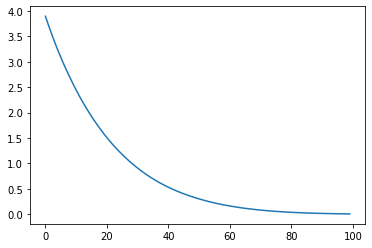

In [7]:
# checking that data is correctly generated
m = tf.keras.Sequential([tf.keras.layers.Dense(2)])
m.compile('adam', 'mse')
h = m.fit(xs, ys, epochs=100, verbose=0)
plt.plot(h.history['loss'])
print(m.evaluate(xs, ys))
print(m.weights)
print(matrix_dist(m.weights[0].numpy().T, A))

In [169]:
def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    if np.linalg.norm(v) <= 
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

In [175]:
projection_simplex_sort(np.array([1,0.1]), 3)

array([1.95, 1.05])

In [168]:
class MaxNorm1(tf.keras.constraints.Constraint):
  def __init__(self, max_value=2, axis=0):
    self.max_value = max_value
    self.axis = axis

  def __call__(self, w):
    norms = K.sqrt(
        math_ops.reduce_sum(math_ops.square(w), axis=self.axis, keepdims=True))
    desired = K.clip(norms, 0, self.max_value)
    return w * (desired / (K.epsilon() + norms))

  def get_config(self):
    return {'max_value': self.max_value, 'axis': self.axis}

In [357]:
#%%pixie_debugger

l1coeff = 1e-2
l2coeff = 0
sparsity = 0.3

pruning_params = {
        'pruning_schedule': pruning_sched.ConstantSparsity(0.9, 0),
        #'pruning_schedule': pruning_sched.PolynomialDecay(0, 0.3, 0, 100),
        'block_size': (1, 1),
        'block_pooling_type': 'AVG'
    }

def component_diff_normalized(v):
    """How much the vector is close to (1,0) or (0,1)."""
    v = np.abs(v)
    return 1. - (max(v) - min(v)) / max(v)

def vec_angle_normalized(v1, v2):
    """Cos betweeen vectors."""
    return np.abs(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

def repr_quality(A):
    """Loss for representation quality for matrix A."""
    [s_1, s_2] = A.T # basis vectors = columns
    return component_diff_normalized(s_1) + \
           component_diff_normalized(s_2) + \
           vec_angle_normalized(s_1, s_2)

eps = {'m': 1e-3, 'd': 1e-3, 'e': 1e-3} # eps=0... -- very small distance DE-I

def get_results(l1coeff):
    
    inp_dec = tf.keras.Input(shape=(2,))
    
    decoder = tf.keras.Sequential([ #D
        inp_dec,
        tf.keras.layers.Dense(2, activation=None, use_bias=False, #kernel_regularizer=tf.keras.regularizers.l2(l2coeff),
                             #kernel_initializer='random_normal',
                             #kernel_constraint=tf.keras.constraints.UnitNorm()
                             kernel_constraint=tf.keras.constraints.MinMaxNorm(0.5, 1.5) # == 1 -- 
                             ),
    ])
    
    decoder.layers[-1].set_weights([np.linalg.inv(Q1).T + np.ones((2, 2)) * eps['d']])
    #decoder.layers[-1].set_weights([np.linalg.inv(Q1).T + np.random.randn(2, 2) * 0])
    
    # encoder model -- imitates the RL agent which has converged to something -- and needs to reconstruct the state
    # but the policy is "fixed" and the reward = max
    encoder_model = tf.keras.Sequential([ # E
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(2, activation=None, use_bias=False, #kernel_regularizer=tf.keras.regularizers.l2(l2coeff),
                             #kernel_initializer='random_normal',
                             #kernel_constraint=tf.keras.constraints.UnitNorm()
                              
                             # how can we take the scale out of this -- decompose 
                             kernel_constraint=tf.keras.constraints.MinMaxNorm(0.5, 1.5)
                             ),
    ])
    
    encoder_model.layers[-1].set_weights([Q1.T + np.ones((2, 2)) * eps['e']])
    #encoder_model.layers[-1].set_weights([np.linalg.inv(decoder.get_weights()[0])])

    # maps observations to features
    model = tf.keras.Sequential([ # M
        m_passthrough_action(decoder, 2, 2), # D
        tf.keras.Input(shape=(4,)),
        #prune.prune_low_magnitude(
            tf.keras.layers.Dense(2, activation=None, use_bias=False, kernel_regularizer=tf.keras.regularizers.l1(l1coeff),
                                 #kernel_initializer='random_normal'
                                 ), # M_D
        #**pruning_params)
    ])
    
    model.layers[-1].set_weights([A.T + np.ones((4, 2)) * eps['m']])
    
    def loss_with_decoder(y_true, y_pred, x=None):
        L = tf.reduce_mean(tf.abs(y_pred - decoder(y_true)))
        if x is not None:
            x = x[:,:2]
            L += .5 * tf.reduce_mean(tf.abs(encoder_model(decoder(x)) - x))
        return L
    
    optimizer = tf.keras.optimizers.SGD(lr=0.000001)

    def step(xs, ys):
        with tf.GradientTape() as tape:
            # Make prediction
            pred_y = model(np.array(xs, dtype=np.float32))
            # Calculate loss
            model_loss = loss_with_decoder(ys, pred_y, xs)
        model_loss_nodec = loss_with_decoder(ys, pred_y, x=None)

        # Calculate gradients
        model_gradients = tape.gradient(model_loss, model.trainable_variables)
        # Update model
        optimizer.apply_gradients(zip(model_gradients, model.trainable_variables))
        return model_loss_nodec.numpy()


    model.compile(optimizer='adam', loss=loss_with_decoder)
    
    
    #step_callback = pruning_callbacks.UpdatePruningStep()
    model.optimizer = optimizer
    #step_callback.set_model(model)
    

    #step_callback.on_train_begin()
    
    unused_arg = -1
   
    losses = []
    distances = []
    
    DE = decoder.weights[0].numpy().T @ Q1
    distances.append(repr_quality(DE))
    
    for _ in tqdm(range(200)):
        
        x_train = xs_e
        y_train = ys_e
        batch_size=16
        epochs = 1
        bat_per_epoch = int(len(x_train) / batch_size)
        for epoch in range(epochs):
            #print('=', end='')
            L = []
            for i in range(bat_per_epoch):
                #step_callback.on_train_batch_begin(batch=-1)
                n = i * batch_size
                loss = step(x_train[n:n+batch_size], y_train[n:n+batch_size])
                l = model.layers[-1]
                w = l.get_weights()[0]
                w[np.abs(w) < 1e-1] = 0
                l.set_weights([w])
                L.append(loss)
                #step_callback.on_train_batch_end(batch=i)
            #step_callback.on_epoch_end(batch=-1)
            #step_callback.on_epoch_end(-1)
            #print(model.get_weights())
            
            losses.append(np.mean(L))
                
        
        #h = model.fit(xs_e, ys_e, epochs=10, batch_size=16, verbose=0)#, callbacks=[pruning_callbacks.UpdatePruningStep()])
        
        DE = decoder.weights[0].numpy().T @ Q1
        #DE = DE / DE[0, 0]
        #dist = matrix_dist(DE, np.eye(2)) # it can swap them as well...
        #l1, l2 = np.linalg.eig(DE.T @ DE)[0]
        #DE = DE / np.max(DE, axis=0)
        #dist = min(matrix_dist(DE, np.eye(2)), matrix_dist(DE, np.eye(2)[:,[1,0]]))
        dist = repr_quality(DE)
        #dist = np.abs(np.abs(l1) - np.abs(l2))
        
        distances.append(dist)
    #step_callback.on_train_end()
    loss = model.evaluate(xs_e, ys_e, verbose=0)
    losses.append(loss)
    return losses, distances, model, DE, encoder_model

#losses, distances, model, DE, encoder_model = get_results(1e-3)

First success -- try with 1e-2 for ED and 5e-1 for the M

In [358]:
losses, distances, model, DE, encoder_model = get_results(0)

  0%|          | 0/200 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 200/200 [01:19<00:00,  2.52it/s]


In [359]:
losses, distances, model, DE, encoder_model

([0.0024013703,
  0.0023122802,
  0.0022289914,
  0.0021465425,
  0.0020650786,
  0.0019845723,
  0.001904965,
  0.0018262867,
  0.0017486522,
  0.0016715883,
  0.0015954709,
  0.0015208563,
  0.0014481081,
  0.0013767113,
  0.0013075859,
  0.0012409866,
  0.0011769676,
  0.0011158256,
  0.0010574788,
  0.0010018513,
  0.0009486771,
  0.0008988295,
  0.000852211,
  0.0008084159,
  0.00076735223,
  0.00072898366,
  0.00069328526,
  0.00065995957,
  0.0006288153,
  0.00059952063,
  0.0005716419,
  0.00054525345,
  0.00052039494,
  0.0004965218,
  0.00047415346,
  0.0004531192,
  0.00043301782,
  0.00041382643,
  0.00039556331,
  0.00037826382,
  0.00036177933,
  0.0003458926,
  0.00033091917,
  0.00031629892,
  0.00030226336,
  0.0002887903,
  0.0002759114,
  0.00026346612,
  0.0002512271,
  0.00023943468,
  0.00022809055,
  0.00021698295,
  0.00020613748,
  0.00019542084,
  0.0001848587,
  0.00017455542,
  0.00016436123,
  0.00015424153,
  0.00014423745,
  0.00013425422,
  0.00012432557

In [360]:
DE

array([[1.00027393e+00, 5.71891793e-08],
       [2.94816813e-05, 1.00050347e+00]])

In [361]:
model.get_weights()

[array([[-1.0545887 ,  0.17583065],
        [ 0.08391362, -0.6292486 ]], dtype=float32),
 array([[0.9999998, 0.       ],
        [0.       , 0.9999996],
        [1.0002741, 0.       ],
        [0.       , 1.0005044]], dtype=float32)]

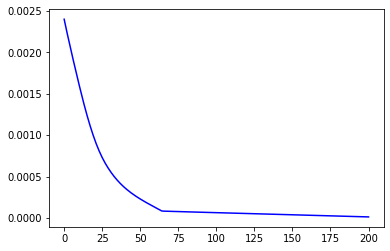

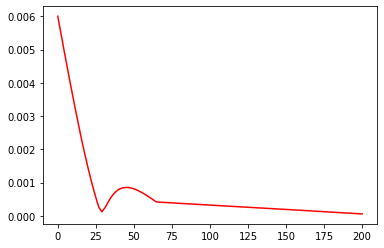

In [362]:
plt.plot(losses, color='blue')
plt.show()
plt.plot(distances, color='red')
plt.show()

In [319]:
model.get_weights()[1].T

array([[0.99929816, 0.        , 0.9936798 , 0.        ],
       [0.        , 1.0001411 , 0.        , 0.9870454 ]], dtype=float32)

In [320]:
model.get_weights()

[array([[-1.0416505 ,  0.18170384],
        [ 0.06771252, -0.6218136 ]], dtype=float32),
 array([[0.99929816, 0.        ],
        [0.        , 1.0001411 ],
        [0.9936798 , 0.        ],
        [0.        , 0.9870454 ]], dtype=float32)]

In [321]:
DE

array([[ 0.99211537,  0.02467143],
       [-0.00768365,  0.98765303]])

In [322]:
l1regs = np.logspace(-5, -3, 5)
repetitions = 2

  0%|          | 0/200 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



 32%|███▏      | 64/200 [00:25<00:54,  2.50it/s]


KeyboardInterrupt: 

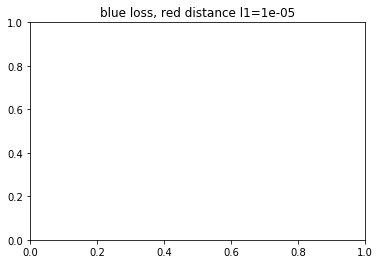

In [323]:
for l1 in l1regs:
    plt.figure()
    plt.title("blue loss, red distance l1=%s" % str(l1))
    for _ in range(repetitions):
        losses, distances, _, _, _ = get_results(l1)
        plt.plot(losses, color='blue')
        plt.plot(distances, color='red')
    plt.axhline(0)
    plt.ylim(0, 10)
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


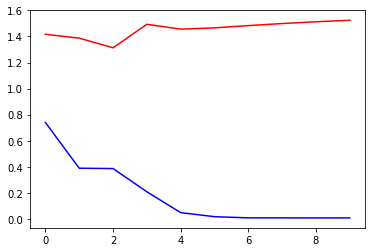

In [172]:
losses, distances, model, DE, enc_model = get_results(1e-3)
plt.plot(losses, color='blue')
plt.plot(distances, color='red')

In [171]:
DE

array([[1.01115143, 1.27647053],
       [0.01448598, 0.65488406]])

In [165]:
model.weights

[<tf.Variable 'dense_349/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.8578968 ,  0.6711588 ],
        [-0.67867035, -0.35187235]], dtype=float32)>,
 <tf.Variable 'dense_351/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[ 1.00011015e+00,  3.45473236e-04],
        [-1.40743126e-04,  9.99669671e-01],
        [ 1.01090324e+00,  1.45456055e-02],
        [ 1.27668142e+00,  6.56009495e-01]], dtype=float32)>]

In [166]:
enc_model.weights

[<tf.Variable 'dense_350/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.46473598, -0.8858308 ],
        [ 0.89586246, -1.1324092 ]], dtype=float32)>]

Problem: the example doesn't work
Anothe problem: $|\lambda_1|\approx|\lambda_2|$ is only a necessary condition but not sufficient...

And it's also not necessary -- can have (1, 2) and then it's not about this at all...

In [78]:
model.weights

[<tf.Variable 'dense_275/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.4931337 ,  1.1180147 ],
        [-0.08453786, -0.19184949]], dtype=float32)>,
 <tf.Variable 'dense_276/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[ 0.19569884, -0.40586734],
        [ 0.35487092,  1.1795061 ],
        [-0.1481647 , -0.3354655 ],
        [ 0.15505023,  0.35242257]], dtype=float32)>]

In [169]:
[s1, s2] = enc_model.weights[0].numpy().T
model.weights[0], s1, s2
vec_angle_normalized(s1, s2)

0.41544253

In [170]:
s1/s2 # it is bad... two features are the same.

array([ 0.5246329 , -0.79111195], dtype=float32)

How to regularize foe the number of non-zero elements? Use SparseSep instead of l1 https://arxiv.org/pdf/1701.06967.pdf

How to evaluate the transform $DE=?$ it should be the right vectors, but they can be scaled and permuted. Therefore, we use the following metric: L1+L2+L3, where L1=difference between two components for first vector, L2 for the second and L3 the dot product between the two (should be 0)

add constraint on mean/variance of features?

In [16]:
A = np.random.randn(2, 2)
A

array([[ 0.11062729,  1.0961417 ],
       [ 2.01711932, -0.97958002]])

In [21]:
s_2

array([ 1.0961417 , -0.97958002])

In [45]:
repr_quality(A)

1.573023080126135

In [46]:
A

array([[ 0.11062729,  1.0961417 ],
       [ 2.01711932, -0.97958002]])

In [47]:
repr_quality(np.eye(2))

0.0

In [57]:
component_diff_normalized([-1000,2])

0.0020000000000000018